In [1]:
#Load up the required packages
library(phyloseq)
library(ggplot2)
library(vegan)
library(reshape2)
library(stringr)
library(ape)

library(dplyr)
library(data.table)

sessionInfo()

Loading required package: permute

Loading required package: lattice

This is vegan 2.5-5


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following objects are masked from ‘package:reshape2’:

    dcast, melt




R version 3.5.2 (2018-12-20)
Platform: x86_64-redhat-linux-gnu (64-bit)
Running under: Fedora 28 (Workstation Edition)

Matrix products: default
BLAS/LAPACK: /usr/lib64/R/lib/libRblas.so

locale:
 [1] LC_CTYPE=en_GB.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_GB.UTF-8        LC_COLLATE=en_GB.UTF-8    
 [5] LC_MONETARY=en_GB.UTF-8    LC_MESSAGES=en_GB.UTF-8   
 [7] LC_PAPER=en_GB.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_GB.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] data.table_1.12.2 dplyr_0.8.4       ape_5.3           stringr_1.4.0    
 [5] reshape2_1.4.3    vegan_2.5-5       lattice_0.20-38   permute_0.9-5    
 [9] ggplot2_3.2.1     phyloseq_1.26.1  

loaded via a namespace (and not attached):
 [1] pbdZMQ_0.3-3        tidyselect_0.2.5    repr_1.0.1         
 [4] purrr_0.3.3     

In [3]:
#Assuming the data is conatined in files with names matching *.biom.json 
biomlist <- list.files('Inputs/biom_files/', '*.json', full.names = T)
prj_names <- gsub('\\.biom\\.json','\\1',basename(biomlist))
nmgsdirs <- paste('./NMGS_processing_3/',prj_names, sep="")

In [4]:
#Only required if performing NMGS theta calculations
for (p in nmgsdirs)
#Create the base NMGS directory
    dir.create(p, recursive = T)


In [5]:
classify_data <- read.csv('Inputs/Taxa_Classifications_20200818_only_genus.csv', header = T, comment.char = '#', stringsAsFactors = F )
metabolic_energies <- read.csv('Inputs/Energies_with_RET.csv')

In [11]:
met_paths <- unique(classify_data$Metabolism)
names(met_paths) <- met_paths

#Build up Taxa search expressions for them
Taxa_Search_Expressions <- lapply(met_paths, FUN = function(n){
  X = classify_data[classify_data$Metabolism==n,]
  d <- apply(X, 1, function(X) paste(X[[2]],'=="',X[[1]],'"',sep=''))
  searchstr  = paste(unlist(d),collapse = ' | ')
  parse(text=searchstr)
})


In [12]:
PSobjs_full <- sapply(biomlist, function(x) import_biom(x, parseFunction = parse_taxonomy_greengenes))

Warning message in parseFunction(i$metadata$taxonomy):
“No greengenes prefixes were found. 
Consider using parse_taxonomy_default() instead if true for all OTUs. 
Dummy ranks may be included among taxonomic ranks now.”
Warning message in parseFunction(i$metadata$taxonomy):
“No greengenes prefixes were found. 
Consider using parse_taxonomy_default() instead if true for all OTUs. 
Dummy ranks may be included among taxonomic ranks now.”
Warning message in parseFunction(i$metadata$taxonomy):
“No greengenes prefixes were found. 
Consider using parse_taxonomy_default() instead if true for all OTUs. 
Dummy ranks may be included among taxonomic ranks now.”
Warning message in parseFunction(i$metadata$taxonomy):
“No greengenes prefixes were found. 
Consider using parse_taxonomy_default() instead if true for all OTUs. 
Dummy ranks may be included among taxonomic ranks now.”


In [13]:
PSobjs_full

$`Inputs/biom_files//AmericanGut_ERP012803.biom.json`
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 12886 taxa and 462 samples ]
tax_table()   Taxonomy Table:    [ 12886 taxa by 7 taxonomic ranks ]

$`Inputs/biom_files//Atlantic_ERP012887.biom.json`
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 15667 taxa and 385 samples ]
tax_table()   Taxonomy Table:    [ 15667 taxa by 7 taxonomic ranks ]

$`Inputs/biom_files//CanadaWater_ERP012927.biom.json`
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 23828 taxa and 388 samples ]
tax_table()   Taxonomy Table:    [ 23828 taxa by 7 taxonomic ranks ]

$`Inputs/biom_files//Donna_ADSludge.biom.json`
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 11585 taxa and 22 samples ]
tax_table()   Taxonomy Table:    [ 11585 taxa by 7 taxonomic ranks ]

$`Inputs/biom_files//DuckWater_ERP012631.biom.json`
phyloseq-class experiment-level object
otu_table() 

In [14]:
tt <- lapply(PSobjs_full, function(x) {unique(as.vector(tax_table(x)[,"Genus"]))})

In [15]:
write.table(unique(as.vector(unlist(tt))), "Detected_genera.tsv",sep="\t")

In [16]:
PSobjs_rare <- sapply(names(PSobjs_full), function(n){
    ps <- PSobjs_full[[n]]
    h = hist(sample_sums(ps), breaks=40, plot=F)
    top_80 = which(cumsum(h$counts) / sum(h$counts) > 0.2)[[1]]
    rarefy_even_depth(ps, sample.size = h$mids[[top_80]])
    })


You set `rngseed` to FALSE. Make sure you've set & recorded
 the random seed of your session for reproducibility.
See `?set.seed`


...

104 samples removedbecause they contained fewer reads than `sample.size`.

Up to first five removed samples are: 


ERR1090786ERR1090787ERR1090789ERR1090812ERR1090820	

...

2096OTUs were removed because they are no longer 
present in any sample after random subsampling


...

You set `rngseed` to FALSE. Make sure you've set & recorded
 the random seed of your session for reproducibility.
See `?set.seed`


...

74 samples removedbecause they contained fewer reads than `sample.size`.

Up to first five removed samples are: 


ERR1102990ERR1102991ERR1102992ERR1102993ERR1102994	

...

3583OTUs were removed because they are no longer 
present in any sample after random subsampling


...

You set `rngseed` to FALSE. Make sure you've set & recorded
 the random seed of your session for reproducibility.
See `?set.seed`


...

84 samples removedbecause they con

In [17]:
#Named list for all results
all_filtered_list = list()

for (i in seq(length(PSobjs_full))){
    curbiom = PSobjs_full[[i]]
    filtered_list <- lapply(Taxa_Search_Expressions, function(x){
                                return(tryCatch(do.call(subset_taxa, list(curbiom,x)),error=function(e) NULL))
                            })
    filtered_list = filtered_list[!sapply(filtered_list, is.null)]
    all_filtered_list[[prj_names[[i]]]] <- filtered_list
                        
}

In [18]:
#Named list for all results
all_filtered_rare = list()

for (i in seq(length(PSobjs_rare))){
    curbiom = PSobjs_rare[[i]]
    filtered_list <- lapply(Taxa_Search_Expressions, function(x){
                                return(tryCatch(do.call(subset_taxa, list(curbiom,x)),error=function(e) NULL))
                            })
    filtered_list = filtered_list[!sapply(filtered_list, is.null)]
    all_filtered_rare[[prj_names[[i]]]] <- filtered_list
                        
}

In [19]:
allprojects <- list()
genusprojects <- list()
for (i in seq(length(all_filtered_list))){
    raw = PSobjs_full[[i]]
    genus_raw  = tax_table(raw)[!is.na(tax_table(raw)[,"Genus"]),]
    flt = all_filtered_list[[i]]
    allprojects[[names(all_filtered_list)[[i]]]] = sum(sapply(flt, function(x) sum(otu_table(x)))) / sum(otu_table(raw)) * 100
    genusprojects[[names(all_filtered_list)[[i]]]] = sum(sapply(flt, function(x) sum(otu_table(x)))) / sum(otu_table(raw)[rownames(genus_raw),]) * 100    
}
t(rbind(as.data.frame(allprojects), as.data.frame(genusprojects)))

AmericanGut_ERP012803,38.875618,70.08174
Atlantic_ERP012887,13.905109,39.59167
CanadaWater_ERP012927,11.881175,29.72283
Donna_ADSludge,18.410252,39.50700
DuckWater_ERP012631,45.669907,60.85443
Hydrothermal_ERP011826,4.765127,46.48328
Lise_Soils,10.003394,42.25596
MalawianChildren_ERP005437,52.056540,67.18932
Marine_ERP013553,43.660882,77.33934
MexicanSoil_SRP037963,19.629371,74.40627
ParkGrass_SRP044877,9.185095,36.80031


In [20]:
#Generate NMGS input files

for (i in seq(length(all_filtered_list))){
    curbiom <- all_filtered_list[[i]]
    for (x in names(curbiom)){
        outfname = paste(nmgsdirs[[i]],'/',x,'.csv', sep = '')
        write.csv(curbiom[[x]]@otu_table, outfname)
    }
}

For efficiency, the actual NMGS jobs are run on a seperate HPC system, using the following Grid Engine submission script:

``` bash
#!/bin/bash
 
#$ -pe smp 4
#$ -cwd -V
#$ -q all.q,bigmem.q
#$ -l h_vmem=16g
 
fname=$1
 
bname=`basename $fname`
 
module add libs/gsl
 
if [ ! -e out_$bname.csv.csv ]
then
        ~/NMGS/C/NMGS -in $fname -out out_$bname -v -nt $NSLOTS -lm
fi
 
```



And the following code is used to pre-process the NMGS outputs


``` R
library(plyr)
library(NMGS)

dirlist = gsub('\\.\\/\\/?','',list.dirs(path = './', ))[-1]

allsets <- list()


for (dir in dirlist){
  curset <- list()
  curset\$dirname = dir
  for (f in list.files(dir, 'out*')){
    nmgs_res <- read_nmgs(paste(dir,f,sep='/'))
    theta <- nmgs_posterior_summaries(nmgs_res, burnin = 25000, thinning = 10)["theta","median"]
    type = gsub("out_(.*)\\.csv\\.csv","\\1",f)
    curset[type] = theta
  }
  save(curset, file=paste('results_',dir,'.RData', sep=""))
  allsets[[dir]] = curset
}


save(allsets, file="allsets.save.RData")

flist = list.files('./', 'results.*')
prjlist = gsub('results_(.*)\\.RData','\\1',flist)
for (f in flist){
  load(f)
  allsets[[gsub('results_(.*)\\.RData','\\1',f)]] <- curset
}

fullresults <- rbind.fill(lapply(allsets, data.frame))

fullresults[fullresults==0]=NA

fullresults\$biome = c("Human","Marine","Freshwater","WWT","Freshwater","Volcanic","Marine", "Human","Marine","Soil","Soil","WWT","Marine", "Volcanic")
fullresults\$sample = c("American Gut","Atlantic", "Canadian lakes", "Anaerobic sludge", "Farm water", "Hydrothermal vent", "Arctic soil", "Malawian children", "Baltic", "Mexican soil","Canadian parks", "Severn Trent WWT", "TARA Ocean Survey", "Italian Volcanoes")

fullresults
write.table(fullresults, 'metacommunity_diversity_20180703.txt',sep="\t");




 ```

In [22]:
#Set up the plot axes - for log scales
xbreaks = c(seq(0.001,0.01,0.001),seq(0.01,0.1,0.01), seq(0.1,1,0.1), seq(1,10,1), seq(10,100,10), seq(100,1000,100),seq(1000,10000,1000))
xlabs <- c("0.001",rep("",9),"0.01",rep("",9),"0.1",rep("",9),"1",rep("",9), "10", rep("",9), "100", rep("",9), "1000", rep("",9))

ybreaks = c(seq(0.1,1,0.1),seq(1,10,1), seq(10,100,10), seq(100,1000,100), seq(1000,10000,1000))
ylabs <- c("0.1",rep("",9),"1",rep("",9),"10",rep("",9),"100",rep("",9),"1000",rep("",9))

#Metabolic colours
metab_color_list <-  c("wheat3", "blue","red", "chartreuse3",
                       "darkgoldenrod2","orange","darkred", "purple",
                       "darkgreen", "yellow4", "steelblue3","firebrick2",
                       "indianred", "darkolivegreen4", "honeydew4","cyan", "black")
names(metab_color_list) <- metabolic_energies$Metabolism
metab_label_list = as.character(metabolic_energies$Name)
names(metab_label_list) <- names(metab_color_list)


#Per study labels and colors
study_info_df <- data.frame(
    study=c('AmericanGut_ERP012803', 'Atlantic_ERP012887', 'CanadaWater_ERP012927', 'Donna_ADSludge', 'DuckWater_ERP012631', 'Hydrothermal_ERP011826', 'Lise_Soils', 'MalawianChildren_ERP005437', 'Marine_ERP013553', 'MexicanSoil_SRP037963', 'ParkGrass_SRP044877', 'SevernTrent', 'TARA_ERP001736', 'Volcanic_ERP010094'),
    biome = c("Human","Marine","Freshwater","WWT","Freshwater","Volcanic","Soil", "Human","Marine","Soil","Soil","WWT","Marine", "Volcanic"),
    studylabel = c("American Gut","Atlantic", "Canadian lakes", "Anaerobic sludge", "Farm water", "Hydrothermal vent", "Arctic soil", "Malawian children", "Baltic", "Mexican soil","Canadian parks", "Severn Trent WWT", "TARA Ocean Survey", "Italian Volcanoes")
)

study_name_list = as.character(study_info_df$studylabel)
names(study_name_list) <- as.character(study_info_df$study)
study_biome_list = as.character(study_info_df$biome)
names(study_biome_list) <- as.character(study_info_df$study)
biome_color_list <- c("salmon3","darkseagreen","cornflowerblue","bisque3","darkorange","darkslategray")
names(biome_color_list) <- c("Human", "Marine", "Freshwater", "WWT", "Volcanic", "Soil")


#Carbon source colors + labels
c_src_colours = c("blue","orange")
names(c_src_colours) = c("C","S")

c_src_labels = c("Complex","Simple")
names(c_src_colours) = c("C","S")


# $\alpha$ diversity

In [23]:
#Marine_ERP013553 doesn't have enough diversity per sample (coverage is too low)
all_filtered_list[["Marine_ERP013553"]] <- NULL

In [24]:
alpha_df_list <- lapply(names(all_filtered_list), function(curname){
    curPrj <- all_filtered_list[[curname]]
    
    prj_diversity_df <- do.call(rbind,
            lapply(names(curPrj), function(b){
                df <- estimate_richness(curPrj[[b]], measures = c("Observed","InvSimpson","Shannon", "Chao1"))
                df$metabolism <- b
                df$sample <- rownames(df)
                df$study <- curname
                df
            }))
    prj_diversity_df
})

Warning message in estimate_richness(curPrj[[b]], measures = c("Observed", "InvSimpson", :
“The data you have provided does not have
any singletons. This is highly suspicious. Results of richness
estimates (for example) are probably unreliable, or wrong, if you have already
trimmed low-abundance taxa from the data.

We recommended that you find the un-trimmed data and retry.”
Warning message in estimate_richness(curPrj[[b]], measures = c("Observed", "InvSimpson", :
“The data you have provided does not have
any singletons. This is highly suspicious. Results of richness
estimates (for example) are probably unreliable, or wrong, if you have already
trimmed low-abundance taxa from the data.

We recommended that you find the un-trimmed data and retry.”
Warning message in estimate_richness(curPrj[[b]], measures = c("Observed", "InvSimpson", :
“The data you have provided does not have
any singletons. This is highly suspicious. Results of richness
estimates (for example) are probably unreliabl

In [25]:
#combine all diversities into a single data.frame
alpha_diversity = do.call(rbind,alpha_df_list)

In [26]:
#fixup columns 
#Drop "inf" values - not all samples from all projects contain examples from all metabolisms
alpha_diversity <- alpha_diversity[is.finite(alpha_diversity$InvSimpson),]

#and merge in the metabolic values:
alpha_diversity = merge(alpha_diversity, metabolic_energies, by.x="metabolism", by.y="Metabolism")
      

In [27]:
colnames(alpha_diversity)[colnames(alpha_diversity) == "sample"] <- "samp_name"

In [28]:
alpha_diversity  %>% select(metabolism, InvSimpson, samp_name, study) %>% 
    group_by(samp_name) %>% arrange(desc(InvSimpson)) %>% #summarise(metab=list(metabolism), )
    mutate(ord = InvSimpson / max(InvSimpson)) %>% group_by(metabolism) -> tmpdf

In [29]:
tmpdf %>% group_by(metabolism) %>% summarise(m = mean(ord)) %>% arrange(desc(m))

metabolism,m
<chr>,<dbl>
AerobicResp,0.81019950
Ferm,0.65785310
FeIII_reducer,0.24353780
Fe_oxidizer,0.19960187
Methanotroph,0.18940730
Ammonia_Oxidizer,0.18900776
NOB,0.18294192
H2_Oxidizer,0.16848664
SRB_CO2,0.13288766


In [30]:
#Calulate per-sample linear best fits
alpha_fits_yield <- alpha_diversity %>% group_by(study, samp_name) %>% do(
    as.data.frame(summary(lm(log(InvSimpson) ~ log(yield), data=.))$coefficients, stringsAsFactors = F))


alpha_fits_dgcat <- alpha_diversity %>% group_by(study, samp_name) %>% do(
    as.data.frame(summary(lm(log(InvSimpson) ~ log(-dgcat), data=.))$coefficients, stringsAsFactors = F))

In [31]:
alpha_fits_yield

study,samp_name,Estimate,Std. Error,t value,Pr(>|t|)
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
AmericanGut_ERP012803,ERR1090777,1.09010105,0.15733240,6.9286494,0.09125210
AmericanGut_ERP012803,ERR1090777,0.25855965,0.05841326,4.4263859,0.14144926
AmericanGut_ERP012803,ERR1090778,0.54982499,0.39491857,1.3922490,0.39653625
AmericanGut_ERP012803,ERR1090778,0.08484838,0.14662258,0.5786856,0.66602947
AmericanGut_ERP012803,ERR1090779,1.16698411,0.63396962,1.8407572,0.31681366
AmericanGut_ERP012803,ERR1090779,0.20957642,0.23537577,0.8903908,0.53687139
AmericanGut_ERP012803,ERR1090780,0.75358486,0.95698097,0.7874607,0.57534399
AmericanGut_ERP012803,ERR1090780,0.05626846,0.35530114,0.1583684,0.90000998
AmericanGut_ERP012803,ERR1090781,1.27440314,0.70557653,1.8061870,0.32190242


In [32]:
#Finally, group all samples together and generate the "full" fit across tall samples in a project
alpha_fullfits_yield <- alpha_diversity %>% group_by(study) %>% do(as.data.frame(summary(lm(log(InvSimpson) ~ log(yield), data=.))$coefficients, stringsAsFactors = F))
#Finally, group all samples together and generate the "full" fit across tall samples in a project
alpha_fullfits_dgcat <- alpha_diversity %>% group_by(study) %>% do(as.data.frame(summary(lm(log(InvSimpson) ~ log(-dgcat), data=.))$coefficients, stringsAsFactors = F))

In [33]:
#Relabel the parameters (intercept and slope) that were lost "do" aglomeration
alpha_fits_yield$param = c("intercept","slope")
alpha_fullfits_yield$param = c("intercept","slope")
alpha_fits_dgcat$param = c("intercept","slope")
alpha_fullfits_dgcat$param = c("intercept","slope")

#Reshape the dataframes
alpha_fitsdf_yield <- melt(alpha_fits_yield, id.vars = c("study","samp_name","param")) %>% dcast(study + samp_name ~ param+variable, value.var = "value")
alpha_fullfitsdf_yield <- melt(alpha_fullfits_yield, id.vars = c("study","param")) %>% dcast(study ~ param+variable, value.var = "value")

alpha_fitsdf_dgcat <- melt(alpha_fits_dgcat, id.vars = c("study","samp_name","param")) %>% dcast(study + samp_name ~ param+variable, value.var = "value")
alpha_fullfitsdf_dgcat <- melt(alpha_fullfits_dgcat, id.vars = c("study","param")) %>% dcast(study ~ param+variable, value.var = "value")

rownames(alpha_fullfitsdf_yield) <- alpha_fullfitsdf_yield$study
rownames(alpha_fullfitsdf_dgcat) <- alpha_fullfitsdf_dgcat$study

In [34]:
alpha_fullfitsdf_yield

,study,intercept_Estimate,intercept_Std. Error,intercept_t value,intercept_Pr(>|t|),slope_Estimate,slope_Std. Error,slope_t value,slope_Pr(>|t|)
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AmericanGut_ERP012803,AmericanGut_ERP012803,1.1339482,0.01946757,58.248048,0.000000e+00,0.24460510,0.007075115,34.572598,6.253294e-195
Atlantic_ERP012887,Atlantic_ERP012887,0.9818016,0.01566387,62.679371,0.000000e+00,0.21137259,0.007549042,27.999923,4.176585e-153
CanadaWater_ERP012927,CanadaWater_ERP012927,1.3577114,0.01329807,102.098379,0.000000e+00,0.35649430,0.007094813,50.247176,0.000000e+00
Donna_ADSludge,Donna_ADSludge,1.2205023,0.05314960,22.963529,2.681341e-62,0.28489987,0.024313243,11.717888,2.448163e-25
DuckWater_ERP012631,DuckWater_ERP012631,0.9054710,0.01818275,49.798351,3.135573e-314,0.39600354,0.010996796,36.010812,1.762345e-202
Hydrothermal_ERP011826,Hydrothermal_ERP011826,0.8666073,0.06458679,13.417717,7.811378e-28,0.20801108,0.031558924,6.591197,6.275504e-10
Lise_Soils,Lise_Soils,0.9451972,0.19306428,4.895764,1.163968e-04,0.35017693,0.109426208,3.200119,4.961187e-03
MalawianChildren_ERP005437,MalawianChildren_ERP005437,1.3947208,0.02993935,46.584878,1.404761e-246,0.02856869,0.017249206,1.656232,9.800824e-02
MexicanSoil_SRP037963,MexicanSoil_SRP037963,1.5100105,0.07510288,20.105894,5.259416e-42,0.69983638,0.046051946,15.196673,8.831491e-31


In [35]:
for (curstudy in unique(alpha_fitsdf_dgcat$study)){

    plot_df <- alpha_diversity[alpha_diversity$study == curstudy,]
    
    fits_df_yield <- alpha_fitsdf_yield[alpha_fitsdf_yield$study == curstudy,]
    fits_df_dgcat <- alpha_fitsdf_dgcat[alpha_fitsdf_dgcat$study == curstudy,]



    p_yield <- ggplot(plot_df, aes(x=yield, y=InvSimpson)) +
        theme_bw(base_size = 18, base_family = "arial") +

        #geom_abline(data=fits_df_yield[fits_df_yield$`slope_Pr(>|t|)` <= 0.05,], 
        #              aes(slope=slope_Estimate, intercept=intercept_Estimate), alpha=0.05, color="black") +
        #geom_abline(data=fitdf[fitdf$`slope_Pr(>|t|)` > 0.05,], 
        #              aes(slope=slope_Estimate, intercept=intercept_Estimate), alpha=0.05, color="black") +


        geom_abline(data=fits_df_yield, aes(slope=slope_Estimate, intercept=intercept_Estimate), alpha=0.05, color="black") +

        geom_point(size=5, aes(color=metabolism), alpha=1.0) +
        geom_point(size=2, color="LightBlue", alpha=0.8) + 

        scale_x_continuous(trans = "log", breaks=xbreaks, labels=xlabs) + 
        scale_y_continuous(trans = "log", breaks=ybreaks, labels=ylabs) +  

        scale_color_manual(values = metab_color_list, labels = metab_label_list, name="Metabolic classification" ) +

        xlab(expression("Growth yield : " ~ bgroup("(", over(-Delta*G[cat],Delta*G[ana]+Delta*G[dis]),")"))) +
        ylab(expression(alpha ~ "Diversity (inverse Simpson)"))  +
        geom_abline(slope=alpha_fullfitsdf_yield[curstudy, "slope_Estimate"], intercept = alpha_fullfitsdf_yield[curstudy, "intercept_Estimate"],
                 alpha = 1.0, color="darkgreen", size=2) +
        ggtitle(study_name_list[curstudy]) 


    p_catab <- ggplot(plot_df, aes(x=-dgcat, y=InvSimpson)) +
        theme_bw(base_size = 18, base_family = "arial") +

        #geom_abline(data=fits_df_yield[fits_df_yield$`slope_Pr(>|t|)` <= 0.05,], 
        #              aes(slope=slope_Estimate, intercept=intercept_Estimate), alpha=0.05, color="black") +
        #geom_abline(data=fitdf[fitdf$`slope_Pr(>|t|)` > 0.05,], 
        #              aes(slope=slope_Estimate, intercept=intercept_Estimate), alpha=0.05, color="black") +


        geom_abline(data=fits_df_dgcat, aes(slope=slope_Estimate, intercept=intercept_Estimate), alpha=0.05, color="black") +

        geom_point(size=5, aes(color=metabolism), alpha=1.0) +
        geom_point(size=2, color="LightBlue", alpha=0.8) + 

        scale_x_continuous(trans = "log", breaks=xbreaks, labels=xlabs) + 
        scale_y_continuous(trans = "log", breaks=ybreaks, labels=ylabs) +  

        scale_color_manual(values = metab_color_list, labels = metab_label_list, name="Metabolic classification" ) +
        xlab(expression(-Delta*G[cat](kJmol^-1))) +

        ylab(expression(alpha ~ "Diversity (inverse Simpson)"))  +
        geom_abline(slope=alpha_fullfitsdf_dgcat[curstudy, "slope_Estimate"], intercept = alpha_fullfitsdf_dgcat[curstudy, "intercept_Estimate"],
                 alpha = 1.0, color="darkgreen", size=2) +
        ggtitle(study_name_list[curstudy]) 


    ggsave(paste('output_images/alpha/yield-',curstudy,'.png', sep=""),p_yield,dpi = 600, 
               units="mm", width = 150*2, height = 100*2, limitsize = FALSE) 

    ggsave(paste('output_images/alpha/catab-',curstudy,'.png', sep=""),p_catab,dpi = 600, 
               units="mm", width = 150*2, height = 100*2, limitsize = FALSE) 

}

Warning message:
“Removed 7 rows containing missing values (geom_abline).”
Warning message:
“Removed 7 rows containing missing values (geom_abline).”
Warning message:
“Removed 3 rows containing missing values (geom_abline).”
Warning message:
“Removed 3 rows containing missing values (geom_abline).”


# Metacommunity

In [60]:
#There weren;t any results for SRB_H2 in the studies examined.
metabolic_energies <- metabolic_energies[-c(which(metabolic_energies$Metabolism == "SRB_H2")),] 

In [61]:
#Read in the results from the NMGS runs 
metadf = read.table('./Results//metacommunity_diversity_20200817.txt', sep="\t", stringsAsFactors = F)
#metabolic_energies <- metabolic_energies[-c(which(metabolic_energies$Metabolism == "SRB_H2"))]
metadf <- metadf[,c("dirname", as.character(metabolic_energies$Metabolism))]

md <- melt(metadf, value.name = "theta", variable.name = "metabolism", measure.vars = metabolic_energies$Metabolism, )

theta_df <- merge(md, metabolic_energies, by.x = "metabolism", by.y="Metabolism")
#Drop missing values
theta_df <- theta_df[(!is.na(theta_df$theta)) & (theta_df$theta > 0),]

theta_df

,metabolism,dirname,theta,yield,dgcat,Name,C.Source.type
,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
2,Acet_Methanogen,Atlantic_ERP012887,2.4508165,0.067100,-31.00000,Acetoclastic Methanogen,C
3,Acet_Methanogen,CanadaWater_ERP012927,3.6562220,0.067100,-31.00000,Acetoclastic Methanogen,C
4,Acet_Methanogen,Donna_ADSludge,7.8173345,0.067100,-31.00000,Acetoclastic Methanogen,C
5,Acet_Methanogen,DuckWater_ERP012631,0.2961420,0.067100,-31.00000,Acetoclastic Methanogen,C
7,Acet_Methanogen,Lise_Soils,1.8829685,0.067100,-31.00000,Acetoclastic Methanogen,C
12,Acet_Methanogen,SevernTrent,2.9494670,0.067100,-31.00000,Acetoclastic Methanogen,C
15,AerobicResp,AmericanGut_ERP012803,468.1989960,13.421700,-2841.19969,Aerobic Heterotroph,C
16,AerobicResp,Atlantic_ERP012887,597.7549290,13.421700,-2841.19969,Aerobic Heterotroph,C
17,AerobicResp,CanadaWater_ERP012927,590.4394235,13.421700,-2841.19969,Aerobic Heterotroph,C


In [62]:
theta_fits <- theta_df %>% group_by(dirname) %>% do(data.frame(
    yield=summary(lm(log(theta) ~ log(yield), data=.))$coefficients,
    dgcat=summary(lm(log(theta) ~ log(-dgcat), data=.))$coefficients,stringsAsFactors = F))

theta_fits$param = c("intercept","slope")

In [63]:
theta_fitsdf<- melt(theta_fits, id.vars = c("dirname","param")) %>% dcast(dirname ~ param +variable)

In [64]:
theta_plot_yield <- ggplot(theta_df, aes(x=yield,y=theta)) + theme_bw(base_size = 18, base_family = "arial") +
 
      geom_abline(data=theta_fitsdf, aes(slope=slope_yield.Estimate, intercept=intercept_yield.Estimate), alpha=0.5, color="black") +
      
      geom_point(size=5, aes(color=metabolism), alpha=1.0) +
      geom_point(size=2, color="LightBlue", alpha=0.8) + 
      scale_x_continuous(trans = "log", breaks=xbreaks, labels=xlabs) + 
      scale_y_continuous(trans = "log", breaks=ybreaks, labels=ylabs) +  

      scale_color_manual(values = metab_color_list, labels = metab_label_list, name="Metabolic classification" ) +

      xlab(expression("Growth yield : " ~ bgroup("(", over(-Delta*G[cat],Delta*G[ana]+Delta*G[dis]),")"))) +
      ylab(expression(theta ~ "(metacommunity diversity)"))+
      
      
      ggtitle("Metacommunity diversity:\nall studies") 

theta_plot_dgcat <- ggplot(theta_df, aes(x=-dgcat,y=theta)) + theme_bw(base_size = 18, base_family = "arial") +
 
      geom_abline(data=theta_fitsdf, aes(slope=slope_dgcat.Estimate, intercept=intercept_dgcat.Estimate), alpha=0.5, color="black") +
      
      geom_point(size=5, aes(color=metabolism), alpha=1.0) +
      geom_point(size=2, color="LightBlue", alpha=0.8) + 
      scale_x_continuous(trans = "log", breaks=xbreaks, labels=xlabs) + 
      scale_y_continuous(trans = "log", breaks=ybreaks, labels=ylabs) +  

      scale_color_manual(values = metab_color_list, labels = metab_label_list, name="Metabolic classification" ) +

      xlab(expression(-Delta*G[cat](kJmol^-1))) +
      ylab(expression(theta ~ "(metacommunity diversity)"))+
      
      
      ggtitle("Metacommunity diversity:\nall studies") 


ggsave(paste('output_images2/theta/yield_full.png', sep=""),theta_plot_yield,dpi = 600, 
               units="mm", width = 150*2, height = 100*2, limitsize = FALSE) 
ggsave(paste('output_images2/theta/dgcat_full.png', sep=""),theta_plot_dgcat,dpi = 600, 
               units="mm", width = 150*2, height = 100*2, limitsize = FALSE) 

In [65]:
#Just oceans
theta_plot_yield <- ggplot(theta_df[theta_df$dirname == "TARA_ERP001736",], aes(x=yield,y=theta)) + theme_bw(base_size = 18, base_family = "arial") +
 
      geom_abline(data=theta_fitsdf[theta_fitsdf$dirname=="TARA_ERP001736",], aes(slope=slope_yield.Estimate, intercept=intercept_yield.Estimate), alpha=1.0, color="black") +
      
      geom_point(size=5, aes(color=metabolism), alpha=1.0) +
      geom_point(size=2, color="LightBlue", alpha=0.8) + 
      scale_x_continuous(trans = "log", breaks=xbreaks, labels=xlabs) + 
      scale_y_continuous(trans = "log", breaks=ybreaks, labels=ylabs) +  

      scale_color_manual(values = metab_color_list, labels = metab_label_list, name="Metabolic classification" ) +

      xlab(expression("Growth yield : " ~ bgroup("(", over(-Delta*G[cat],Delta*G[ana]+Delta*G[dis]),")"))) +
      ylab(expression(theta ~ "(metacommunity diversity)"))+
      
      
      ggtitle("Metacommunity diversity:\nTARA") 

theta_plot_dgcat <- ggplot(theta_df[theta_df$dirname == "TARA_ERP001736",], aes(x=-dgcat,y=theta)) + theme_bw(base_size = 18, base_family = "arial") +
 
      geom_abline(data=theta_fitsdf[theta_fitsdf$dirname=="TARA_ERP001736",], aes(slope=slope_dgcat.Estimate, intercept=intercept_dgcat.Estimate), alpha=1.0, color="black") +
      
      geom_point(size=5, aes(color=metabolism), alpha=1.0) +
      geom_point(size=2, color="LightBlue", alpha=0.8) + 
      scale_x_continuous(trans = "log", breaks=xbreaks, labels=xlabs) + 
      scale_y_continuous(trans = "log", breaks=ybreaks, labels=ylabs) +  

      scale_color_manual(values = metab_color_list, labels = metab_label_list, name="Metabolic classification" ) +

      xlab(expression(-Delta*G[cat](kJmol^-1))) +
      ylab(expression(theta ~ "(metacommunity diversity)"))+
      
      
      ggtitle("Metacommunity diversity:\nTARA") 

ggsave('output_images2/theta/TARA-yield.png',theta_plot_yield,dpi = 600,units="mm", width = 150*2, height = 100*2, limitsize = FALSE) 
ggsave('output_images2/theta/TARA-dgcat.png',theta_plot_dgcat,dpi = 600,units="mm", width = 150*2, height = 100*2, limitsize = FALSE) 



In [66]:
theta_plot_yield <- ggplot(theta_df, aes(x=yield,y=theta)) + theme_bw(base_size = 18, base_family = "arial") +
 
      geom_abline(data=theta_fitsdf[theta_fits$dirname=="TARA_ERP001736",], aes(slope=slope_yield.Estimate, intercept=intercept_yield.Estimate), alpha=1.0, color="black") +
      
    
      geom_point(size=5, aes(color=metabolism), alpha=0.1) +
      #geom_point(data=theta_df[theta_df$dirname == "TARA_ERP001736",], aes(x=yield,y=theta), color="black", size=5) +
    
      geom_point(size=2, color="LightBlue", alpha=0.1) + 

      #geom_point(data=theta_df[theta_df$dirname == "TARA_ERP001736",], aes(x=yield,y=theta), color="black", size=5) +
      geom_point(data=theta_df[theta_df$dirname == "TARA_ERP001736",], aes(x=yield,y=theta, color=metabolism), size=5) +
      geom_point(data=theta_df[theta_df$dirname == "TARA_ERP001736",], aes(x=yield,y=theta), color="white", size=3) +
      geom_point(data=theta_df[theta_df$dirname == "TARA_ERP001736",], aes(x=yield,y=theta, color=metabolism), size=1) +
      
      #geom_point(data=theta_df[theta_df$dirname == "TARA_ERP001736",], aes(x=yield,y=theta), color="red", size=2) +

      scale_x_continuous(trans = "log", breaks=xbreaks, labels=xlabs) + 
      scale_y_continuous(trans = "log", breaks=ybreaks, labels=ylabs) +  

      scale_color_manual(values = metab_color_list, labels = metab_label_list, name="Metabolic classification" ) +

      xlab(expression("Growth yield : " ~ bgroup("(", over(-Delta*G[cat],Delta*G[ana]+Delta*G[dis]),")"))) +
      ylab(expression(theta ~ "(metacommunity diversity)"))+
      
      
      ggtitle("Metacommunity diversity:\nTARA") 

theta_plot_dgcat <- ggplot(theta_df[theta_df$dirname == "TARA_ERP001736",], aes(x=-dgcat,y=theta)) + theme_bw(base_size = 18, base_family = "arial") +
 
      geom_abline(data=theta_fitsdf[theta_fits$dirname=="TARA_ERP001736",], aes(slope=slope_dgcat.Estimate, intercept=intercept_dgcat.Estimate), alpha=1.0, color="black") +
      
      geom_point(size=5, aes(color=metabolism), alpha=1.0) +
      geom_point(size=2, color="LightBlue", alpha=0.8) + 
      scale_x_continuous(trans = "log", breaks=xbreaks, labels=xlabs) + 
      scale_y_continuous(trans = "log", breaks=ybreaks, labels=ylabs) +  

      scale_color_manual(values = metab_color_list, labels = metab_label_list, name="Metabolic classification" ) +

      xlab(expression(-Delta*G[cat](kJmol^-1))) +
      ylab(expression(theta ~ "(metacommunity diversity)"))+
      
      
      ggtitle("Metacommunity diversity:\nTARA") 

ggsave('output_images2/theta/TARA-full_yield_highlighted.png',theta_plot_yield,dpi = 600,units="mm", width = 150*2, height = 100*2, limitsize = FALSE) 
ggsave('output_images2/theta/TARA-full_dgcat.png',theta_plot_dgcat,dpi = 600,units="mm", width = 150*2, height = 100*2, limitsize = FALSE) 



Warning message:
“Removed 2 rows containing missing values (geom_abline).”
Warning message:
“Removed 2 rows containing missing values (geom_abline).”


# Simple carbon source TARA

In [67]:
#Set up the plot axes - for log scales
xbreaks_simple = c(seq(0.001,0.01,0.001),seq(0.01,0.1,0.01), seq(0.1,1,0.1), seq(1,10,1), seq(10,100,10), seq(100,1000,100),seq(1000,10000,1000))
xlabs_simple <- c("0.001",rep("",9),"0.01",rep("",9),"0.1",rep("",9),"1",rep("",9), "10", rep("",9), "100", "","","","500","","","","", "1000", "", rep("",9))

ybreaks_simple = c(seq(0.1,1,0.1),seq(1,10,1), seq(10,100,10), seq(100,1000,100), seq(1000,10000,1000))
ylabs_simple <- c("0.1",rep("",9),"1",rep("",9),"10","20","30","40","50","60","70","80","90","100","",rep("",9),"1000",rep("",9))

In [68]:
 theta_df %>% group_by(dirname) %>% filter((dirname=="TARA_ERP001736") & C.Source.type=="S") -> simple_df 
summary(lm(log(theta) ~ log(yield), data=simple_df))


Call:
lm(formula = log(theta) ~ log(yield), data = simple_df)

Residuals:
       1        2        3        4        5        6        7 
 0.04781  0.76798 -0.16332  0.08189 -0.94600 -0.02216  0.23379 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   2.6892     0.2806   9.584  0.00021 ***
log(yield)    0.1876     0.1506   1.245  0.26824    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.5613 on 5 degrees of freedom
Multiple R-squared:  0.2367,	Adjusted R-squared:  0.08404 
F-statistic:  1.55 on 1 and 5 DF,  p-value: 0.2682


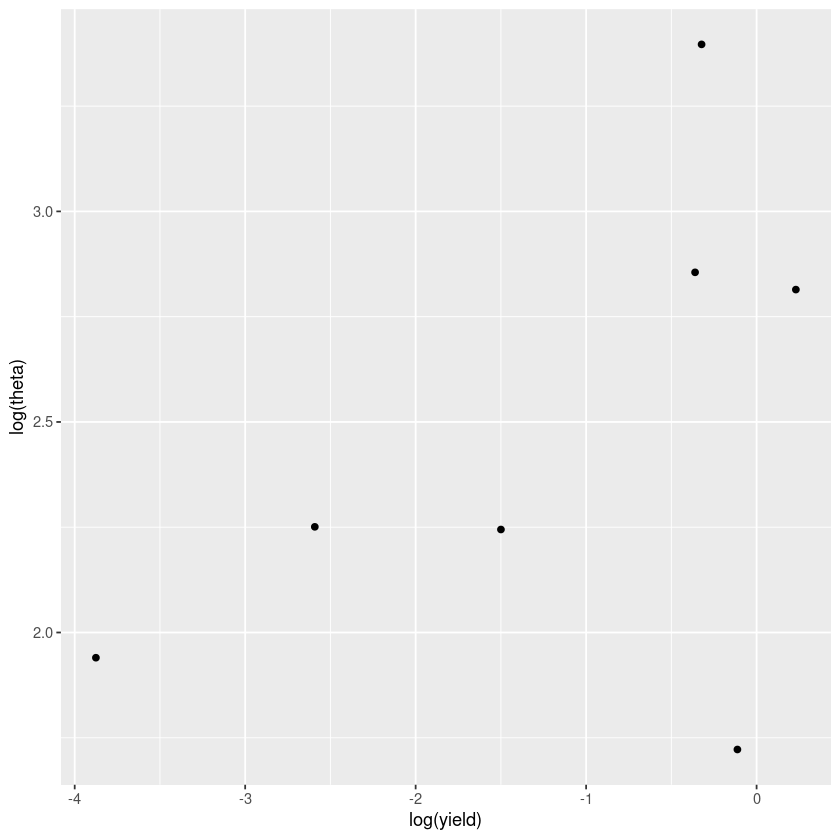

In [69]:
ggplot(simple_df, aes(x=log(yield), y=log(theta))) + geom_point()

In [70]:
theta_fits <- theta_df %>% group_by(dirname) %>% filter((dirname=="TARA_ERP001736") & C.Source.type=="S") %>% do(data.frame(
    yield=summary(lm(log(theta) ~ log(yield), data=.))$coefficients,
    dgcat=summary(lm(log(theta) ~ log(-dgcat), data=.))$coefficients,stringsAsFactors = F))

theta_fits$param = c("intercept","slope")
rownames(theta_fitsdf) <- theta_fitsdf$dirname



theta_fitsdf<- melt(theta_fits, id.vars = c("dirname","param")) %>% dcast(dirname ~ param +variable)

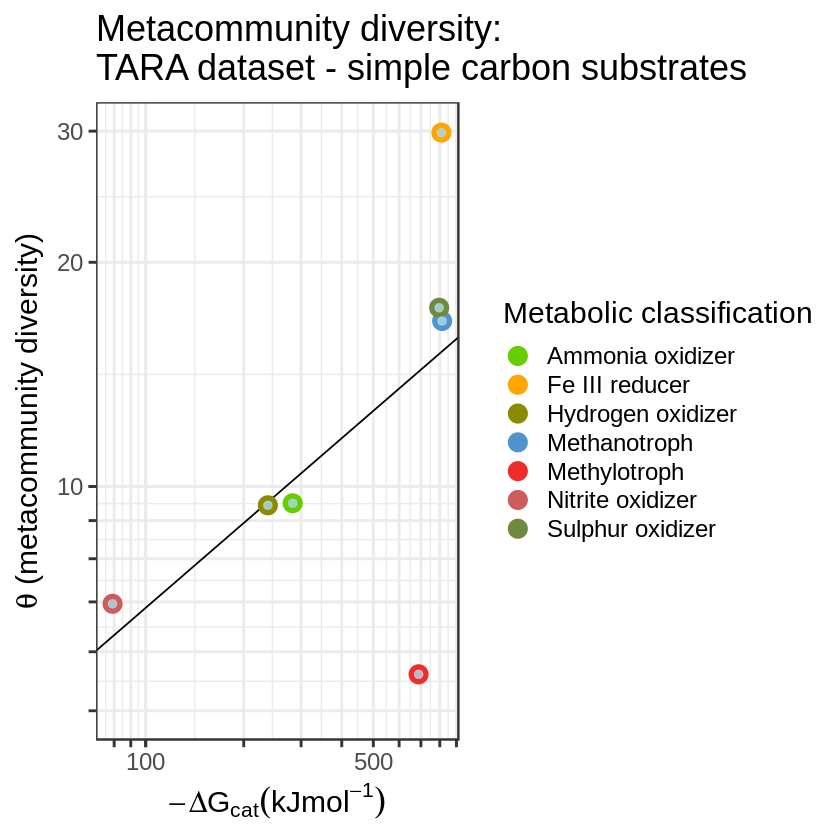

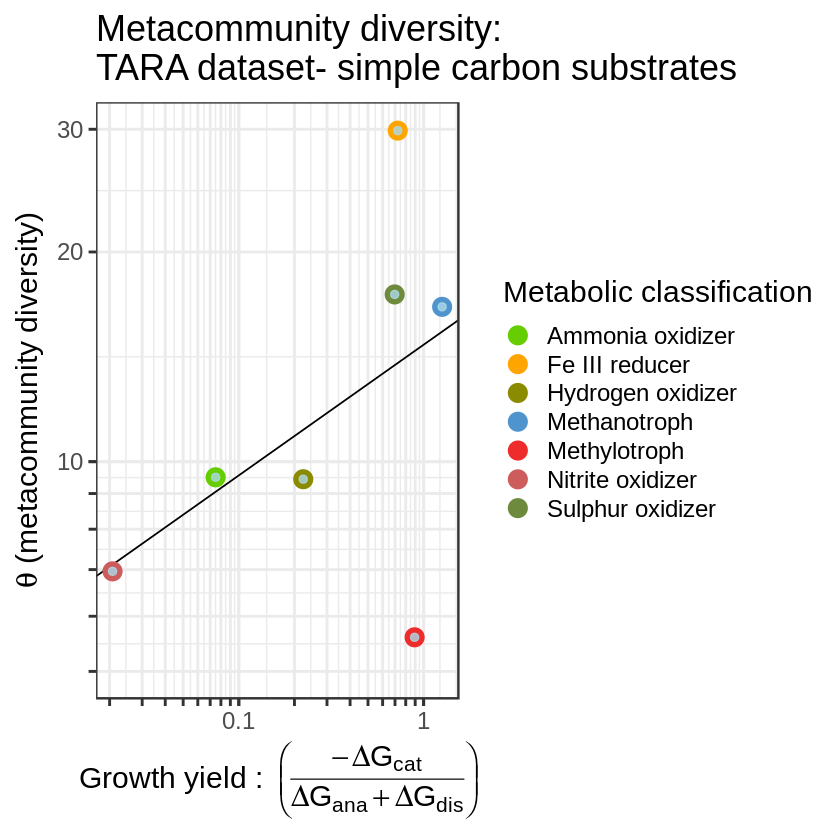

In [71]:
theta_plot_yield <- ggplot(theta_df[(theta_df$dirname=="TARA_ERP001736") & (theta_df$C.Source.type=="S"),], aes(x=yield,y=theta)) + theme_bw(base_size = 18, base_family = "arial") +
 
      geom_abline(data=theta_fitsdf[theta_fitsdf$dirname=="TARA_ERP001736",], aes(slope=slope_yield.Estimate, intercept=intercept_yield.Estimate), alpha=1.0, color="black") +
      
      geom_point(size=5, aes(color=metabolism), alpha=1.0) +
      geom_point(size=2, color="LightBlue", alpha=0.8) + 
      scale_x_continuous(trans = "log", breaks=xbreaks_simple, labels=xlabs_simple) + 
      scale_y_continuous(trans = "log", breaks=ybreaks_simple, labels=ylabs_simple, limits = c(5,30)) +  

      scale_color_manual(values = metab_color_list, labels = metab_label_list, name="Metabolic classification" ) +

      xlab(expression("Growth yield : " ~ bgroup("(", over(-Delta*G[cat],Delta*G[ana]+Delta*G[dis]),")"))) +
      ylab(expression(theta ~ "(metacommunity diversity)"))+
      
      
      ggtitle("Metacommunity diversity:\nTARA dataset- simple carbon substrates") 

theta_plot_dgcat <- ggplot(theta_df[(theta_df$dirname=="TARA_ERP001736") & (theta_df$C.Source.type=="S"),], aes(x=-dgcat,y=theta)) + theme_bw(base_size = 18, base_family = "arial") +
 
      geom_abline(data=theta_fitsdf[theta_fitsdf$dirname=="TARA_ERP001736",], aes(slope=slope_dgcat.Estimate, intercept=intercept_dgcat.Estimate), alpha=1.0, color="black") +
      
      geom_point(size=5, aes(color=metabolism), alpha=1.0) +
      geom_point(size=2, color="LightBlue", alpha=0.8) + 
      scale_x_continuous(trans = "log", breaks=xbreaks_simple, labels=xlabs_simple) + 
      scale_y_continuous(trans = "log", breaks=ybreaks_simple, labels=ylabs_simple, limits = c(5,30)) +  

      scale_color_manual(values = metab_color_list, labels = metab_label_list, name="Metabolic classification" ) +

      xlab(expression(-Delta*G[cat](kJmol^-1))) +
      ylab(expression(theta ~ "(metacommunity diversity)"))+
      
      
      ggtitle("Metacommunity diversity:\nTARA dataset - simple carbon substrates") 

ggsave('output_images2/theta/simple_carbon_TARA-yield.png',theta_plot_yield,dpi = 600,units="mm", width = 150*2, height = 100*2, limitsize = FALSE) 
ggsave('output_images2/theta/simple_carbon_TARA-dgcat.png',theta_plot_dgcat,dpi = 600,units="mm", width = 150*2, height = 100*2, limitsize = FALSE) 

theta_plot_dgcat

theta_plot_yield

In [72]:
## Overall fit
biome_theta_df <- theta_df[(theta_df$dirname=="TARA_ERP001736") & (theta_df$C.Source.type=="S"),]
biom_yield = lm(log(theta) ~ log(yield), biome_theta_df)
biom_dgcat = lm(log(theta) ~ log(-dgcat), biome_theta_df)
    
    


In [73]:
summary(biom_yield)


Call:
lm(formula = log(theta) ~ log(yield), data = biome_theta_df)

Residuals:
      41       97      139      153      167      181      195 
 0.04781  0.76798 -0.16332  0.08189 -0.94600 -0.02216  0.23379 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   2.6892     0.2806   9.584  0.00021 ***
log(yield)    0.1876     0.1506   1.245  0.26824    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.5613 on 5 degrees of freedom
Multiple R-squared:  0.2367,	Adjusted R-squared:  0.08404 
F-statistic:  1.55 on 1 and 5 DF,  p-value: 0.2682


In [74]:
biome_theta_df = merge(theta_df, study_info_df, by.x="dirname", by.y="study")

biome_theta_fits <- biome_theta_df %>% group_by(biome) %>% do(data.frame(
    yield=summary(lm(log(theta) ~ log(yield), data=.))$coefficients,
    dgcat=summary(lm(log(theta) ~ log(-dgcat), data=.))$coefficients,stringsAsFactors = F))

biome_theta_fits$param = c("intercept","slope")
#rownames(biome_theta_fits) <- biome_theta_fits$biome

biome_theta_fitsdf<- melt(biome_theta_fits, id.vars = c("biome","param")) %>% dcast(biome ~ param +variable)

In [75]:
biome_theta_fitsdf[c("biome","slope_yield.Estimate","slope_yield.Std..Error", "slope_yield.Pr...t..")]

biome,slope_yield.Estimate,slope_yield.Std..Error,slope_yield.Pr...t..
<fct>,<dbl>,<dbl>,<dbl>
Freshwater,0.7509754,0.1727797,2.188835e-04
Human,1.0560983,0.3284289,9.243727e-03
Marine,0.6052185,0.1454379,2.884376e-04
Soil,1.0058884,0.1570973,2.396538e-06
Volcanic,0.4236342,0.2301590,8.861096e-02
WWT,0.9394013,0.2230039,4.280366e-04


In [76]:
mdf_casted <- dcast(biome_theta_df[,c("metabolism", "theta", "biome")], metabolism ~ biome, value.var = "theta", fun.aggregate = mean)
mdf_casted2 <-dcast(biome_theta_df[,c("metabolism", "theta", "dirname")] , metabolism ~ dirname, value.var = "theta")


In [77]:
library(Skillings.Mack)


In [78]:
t(as.matrix(mdf_casted2[,-1]))

AmericanGut_ERP012803,NA,468.19900,NA,1.096111,NA,NA,439.515137,0.8769595,1.824376,3.1744750,NA,NA,1.296654,NA,NA
Atlantic_ERP012887,2.450817,597.75493,9.0076375,1.262893,4.8651885,NA,322.229201,5.2558225,6.038008,4.8236595,2.5334630,6.4202050,6.567639,6.581710,NA
CanadaWater_ERP012927,3.656222,590.43942,1.3788960,1.987423,22.0316570,NA,184.297307,5.0045780,6.445979,10.3744790,2.0913310,0.3491725,6.961468,2.843653,15.657626
Donna_ADSludge,7.817335,399.82677,NA,1.062202,17.0113430,NA,358.259532,10.6991745,3.315122,5.5350185,NA,0.1651135,6.778104,2.114214,NA
DuckWater_ERP012631,0.296142,689.69312,6.5848435,NA,42.2634115,NA,344.016986,20.0958230,6.221266,15.3624610,0.8628315,0.8566085,6.403798,NA,10.101614
Hydrothermal_ERP011826,NA,98.47656,5.2324845,NA,0.1894005,NA,8.245788,NA,NA,7.3848075,NA,4.7466570,1.838518,NA,7.662928
Lise_Soils,1.882969,113.74345,NA,NA,2.7051775,NA,39.536003,0.8911205,NA,0.5467615,NA,NA,NA,1.291701,NA
MalawianChildren_ERP005437,NA,230.47523,NA,NA,NA,NA,259.989756,NA,10.261330,6.9964030,NA,NA,1.142994,NA,NA
Marine_ERP013553,NA,133.18726,NA,NA,NA,NA,3.788131,NA,41.913054,14.4635635,2.8950220,NA,NA,NA,NA
MexicanSoil_SRP037963,NA,474.30755,0.7433695,NA,4.7686960,NA,65.939893,NA,6.648074,6.8397415,8.0935390,NA,5.652448,NA,NA
ParkGrass_SRP044877,NA,373.12970,NA,NA,16.4566605,NA,188.714294,NA,5.317014,7.5597480,NA,0.1997160,3.957123,1.256928,NA


In [79]:
sk_res <- Ski.Mack(as.matrix(1/mdf_casted[,-1]),simulate.p.value = T, B=100 )


Skillings-Mack Statistic =  42.771674 , p-value =  9.3e-05 
Note: the p-value is based on the chi-squared distribution with d.f. =  14 
Based on B =  100 , Simulated p-value =  0.000000 

$Nblocks
[1] 6

$Ntreatments
[1] 15

$rawdata
          Freshwater          Human         Marine           Soil
 [1,] 0.506026266811            NaN 0.408027283968 0.531076329742
 [2,] 0.001562338224 0.002862564464 0.001874613924 0.003121161298
 [3,] 0.251138300041            NaN 0.108085287506 1.345226028240
 [4,] 0.503164274330 0.912316362120 0.791832407087            NaN
 [5,] 0.031106584792            NaN 0.057588442783 0.125362852329
 [6,]            NaN            NaN            NaN            NaN
 [7,] 0.003785625387 0.002859165130 0.004872185114 0.010197484814
 [8,] 0.079680001925 1.140303514586 0.190265177334 1.122182690220
 [9,] 0.157887534262 0.165484753869 0.052276252672 0.167152970375
[10,] 0.077709315870 0.196639857444 0.083405188061 0.200719230528
[11,] 0.677010827942            NaN 0.2

In [80]:
sk_res

Freshwater,Human,Marine,Soil,Volcanic,WWT
0.506026266811,NaN,0.408027283968,0.531076329742,NaN,0.1857561876663
0.001562338224,0.002862564464,0.001874613924,0.003121161298,0.001523639909,0.0007357092658
0.251138300041,NaN,0.108085287506,1.345226028240,0.191113800719,0.0220208498692
0.503164274330,0.912316362120,0.791832407087,NaN,NaN,0.5893903258061
0.031106584792,NaN,0.057588442783,0.125362852329,0.271586529064,0.0566310131022
NaN,NaN,NaN,NaN,0.148376648186,NaN
0.003785625387,0.002859165130,0.004872185114,0.010197484814,0.004204138738,0.0012711554380
0.079680001925,1.140303514586,0.190265177334,1.122182690220,NaN,0.0787566917346
0.157887534262,0.165484753869,0.052276252672,0.167152970375,NaN,0.2470054601792
0.077709315870,0.196639857444,0.083405188061,0.200719230528,0.085151076423,0.1455987729518


In [81]:
biome_theta_fitsdf

biome,intercept_yield.Estimate,intercept_yield.Std..Error,intercept_yield.t.value,intercept_yield.Pr...t..,intercept_dgcat.Estimate,intercept_dgcat.Std..Error,intercept_dgcat.t.value,intercept_dgcat.Pr...t..,slope_yield.Estimate,slope_yield.Std..Error,slope_yield.t.value,slope_yield.Pr...t..,slope_dgcat.Estimate,slope_dgcat.Std..Error,slope_dgcat.t.value,slope_dgcat.Pr...t..
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Freshwater,3.164490436,0.3853738324,8.211482384,1.982534138e-08,-1.5719808335,1.281781774,-1.2264028595,0.231943988687,0.7509754215,0.1727797473,4.346431994,2.188834958e-04,0.6870023666,0.2261908442,3.037268679,5.678893633e-03
Human,2.785204236,0.5566637185,5.003387401,5.346579008e-04,-5.5866001282,2.952652681,-1.8920613875,0.087763426001,1.0560983328,0.3284288597,3.215607587,9.243726541e-03,1.2901577322,0.4635044489,2.783485110,1.933469187e-02
Marine,3.136630198,0.2830143914,11.082935332,1.495955924e-11,-1.6819571161,1.158731298,-1.4515506041,0.158147900719,0.6052185214,0.1454379453,4.161352255,2.884376145e-04,0.7325343508,0.1924918774,3.805533827,7.386270406e-04
Soil,2.535681743,0.2746167357,9.233529548,7.681301733e-09,-5.3269294164,1.529916627,-3.4818429475,0.002225603046,1.0058884241,0.1570972791,6.402965285,2.396537892e-06,1.1969076908,0.2441048549,4.903252298,7.534479667e-05
Volcanic,2.832247856,0.5431890487,5.214110747,1.669436880e-04,0.3609696174,1.856275786,0.1944590454,0.848822389494,0.4236341524,0.2301590387,1.840614885,8.861095828e-02,0.3585792041,0.3020365075,1.187204842,2.563879817e-01
WWT,3.673758607,0.4536447920,8.098315403,9.647043416e-08,-3.4346268231,1.550917762,-2.2145770112,0.038564400436,0.9394013455,0.2230039028,4.212488364,4.280365697e-04,1.0912570403,0.2701650322,4.039223846,6.418675744e-04


# Generate plot by biome

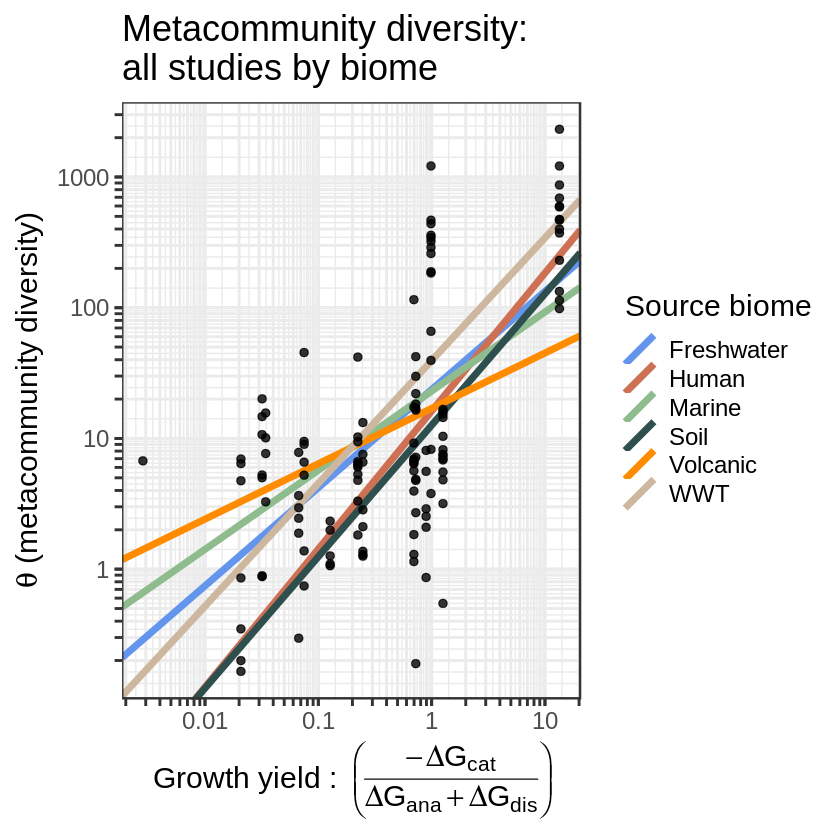

In [82]:
theta_plot_yield <- ggplot(biome_theta_df, aes(x=yield,y=theta)) + theme_bw(base_size = 18, base_family = "arial") +
 
      geom_abline(data=biome_theta_fitsdf, aes(slope=slope_yield.Estimate, intercept=intercept_yield.Estimate, color=biome),
                  alpha=1.0, size=2) +
      
      #geom_point(size=5, aes(color=biome), alpha=1.0) +
      geom_point(size=2, color="black", alpha=0.8) + 
      scale_x_continuous(trans = "log", breaks=xbreaks, labels=xlabs) + 
      scale_y_continuous(trans = "log", breaks=ybreaks, labels=ylabs) +  

      scale_color_manual(values = biome_color_list, name="Source biome" ) +

      xlab(expression("Growth yield : " ~ bgroup("(", over(-Delta*G[cat],Delta*G[ana]+Delta*G[dis]),")"))) +
      ylab(expression(theta ~ "(metacommunity diversity)"))+
      
      
      ggtitle("Metacommunity diversity:\nall studies by biome") 
theta_plot_yield

ggsave('output_images2/theta/metacommunity-all-biome-yield.png',theta_plot_yield,dpi = 600,units="mm", width = 150*2, height = 100*2, limitsize = FALSE) 


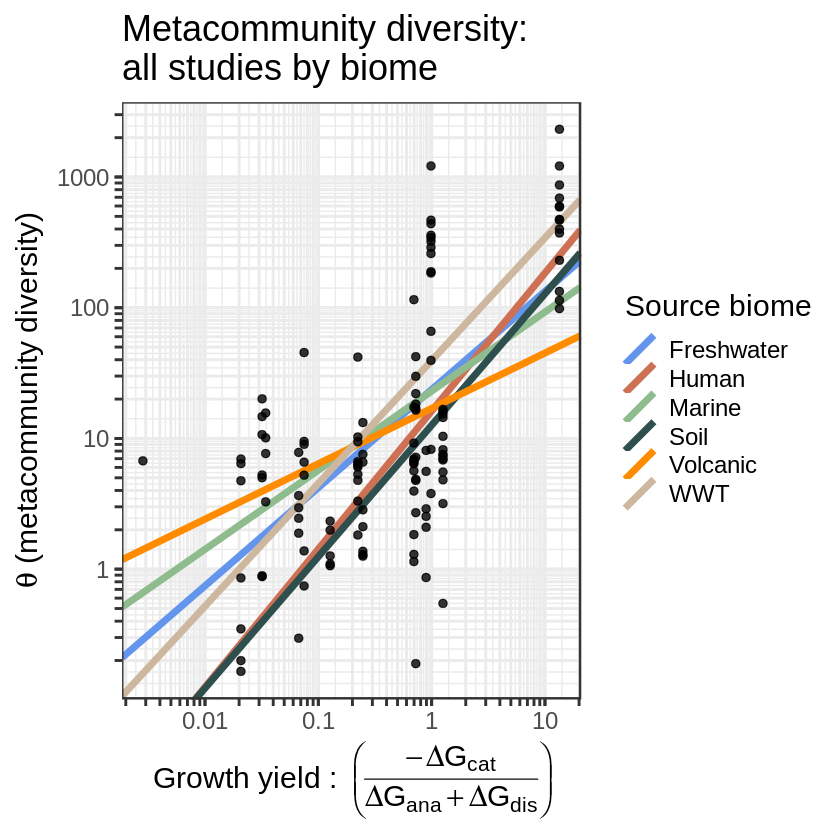

In [83]:
theta_plot_yield

In [84]:
anova(lm(log(theta) ~ log(yield)*biome, biome_theta_df))


,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
log(yield),1,222.97100873,222.971008733,87.429204278,8.464851032e-16
biome,5,16.38556502,3.277113005,1.284989398,2.751823454e-01
log(yield):biome,5,19.19097236,3.838194473,1.504995158,1.936708149e-01
Residuals,115,293.28490653,2.550303535,NA,NA


In [85]:
biome_theta_fitsdf[,c(1,2,5,10,13)][c(1,4,5,2,3)]

biome,slope_yield.Estimate,slope_yield.Pr...t..,intercept_yield.Estimate,intercept_yield.Pr...t..
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
Freshwater,0.7509754215,2.188834958e-04,3.164490436,1.982534138e-08
Human,1.0560983328,9.243726541e-03,2.785204236,5.346579008e-04
Marine,0.6052185214,2.884376145e-04,3.136630198,1.495955924e-11
Soil,1.0058884241,2.396537892e-06,2.535681743,7.681301733e-09
Volcanic,0.4236341524,8.861095828e-02,2.832247856,1.669436880e-04
WWT,0.9394013455,4.280365697e-04,3.673758607,9.647043416e-08


In [86]:
summary(lm(log(theta) ~ log(yield):biome + biome + yield , biome_theta_df))


Call:
lm(formula = log(theta) ~ log(yield):biome + biome + yield, data = biome_theta_df)

Residuals:
       Min         1Q     Median         3Q        Max 
-3.9363818 -0.8716031 -0.1316162  0.6133317  3.8929179 

Coefficients:
                              Estimate  Std. Error  t value   Pr(>|t|)    
(Intercept)                 2.56549162  0.40445447  6.34309 4.6932e-09 ***
biomeHuman                 -0.42099901  0.57875275 -0.72742 0.46845716    
biomeMarine                -0.03898635  0.48542547 -0.08031 0.93612852    
biomeSoil                  -0.63916064  0.49619237 -1.28813 0.20030890    
biomeVolcanic              -0.36966800  0.56000522 -0.66012 0.51051140    
biomeWWT                    0.47153261  0.53465073  0.88195 0.37966228    
yield                       0.18383450  0.05034886  3.65121 0.00039555 ***
log(yield):biomeFreshwater  0.49724319  0.17972583  2.76668 0.00660917 ** 
log(yield):biomeHuman       0.62272584  0.28820908  2.16067 0.03281327 *  
log(yield):biomeMarin

In [87]:
summary(lm(log(theta) ~ log(yield) , biome_theta_df))


Call:
lm(formula = log(theta) ~ log(yield), data = biome_theta_df)

Residuals:
       Min         1Q     Median         3Q        Max 
-4.4600257 -1.2206421 -0.1654962  1.1534210  4.0811991 

Coefficients:
              Estimate Std. Error  t value   Pr(>|t|)    
(Intercept) 3.03137503 0.16000421 18.94559 < 2.22e-16 ***
log(yield)  0.72900451 0.07918766  9.20604  9.882e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.622002 on 125 degrees of freedom
Multiple R-squared:  0.4040556,	Adjusted R-squared:  0.3992881 
F-statistic: 84.75112 on 1 and 125 DF,  p-value: 9.882031e-16


In [88]:
summary(lm(log(theta) ~ log(yield):biome , biome_theta_df))


Call:
lm(formula = log(theta) ~ log(yield):biome, data = biome_theta_df)

Residuals:
       Min         1Q     Median         3Q        Max 
-4.5368546 -1.0983733 -0.1918109  0.9423619  4.0941251 

Coefficients:
                            Estimate Std. Error  t value   Pr(>|t|)    
(Intercept)                3.0189250  0.1588449 19.00549 < 2.22e-16 ***
log(yield):biomeFreshwater 0.7122660  0.1467545  4.85345 3.6891e-06 ***
log(yield):biomeHuman      1.0805123  0.2727414  3.96167 0.00012676 ***
log(yield):biomeMarine     0.5783443  0.1567834  3.68881 0.00033992 ***
log(yield):biomeSoil       1.0868090  0.1925092  5.64549 1.1227e-07 ***
log(yield):biomeVolcanic   0.4523320  0.1765684  2.56179 0.01165133 *  
log(yield):biomeWWT        0.7637658  0.1728553  4.41853 2.1922e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.59841 on 120 degrees of freedom
Multiple R-squared:  0.4444155,	Adjusted R-squared:  0.4166362 
F-statistic: 15.9981

# Phylogenetic diversity

In [36]:
#Load the tree
gg_tree = read_tree_greengenes('Inputs/gg_13_5_otus_99_annotated.tree')
knowntips = gg_tree$tip.label

#load the database entries
gg_dat = read.table('Inputs/gg_13_5_taxonomy.txt', sep="\t", header=F, stringsAsFactors = F)
colnames(gg_dat) <- c("taxid","taxstr")
tree_dat = gg_dat[gg_dat$taxid %in% knowntips,]

In [37]:
m = match(gg_tree$tip.label, rownames(tree_dat))
prunetips = gg_tree$tip.label[is.na(head(m))]
length(prunetips)

[1] 169543

In [38]:
taxdf = as.data.frame(t(as.data.frame(strsplit(gsub('.__', '', as.character(tree_dat$taxstr)), ';'), stringsAsFactors=FALSE)), stringsAsFactors=FALSE)
colnames(taxdf) <- c("Kingdom","Phylum","Class","Order","Family","Genus","Species")
taxdf$taxid <- tree_dat$taxid
rownames(taxdf) <- taxdf$taxid

In [39]:
cleantaxfs = sapply(taxdf,function(x) gsub(' ','',x))

In [40]:
cleandf = data.frame(cleantaxfs, stringsAsFactors = F)
rownames(cleandf) = rownames(taxdf)

In [41]:
#Get lists of tip labels we need to search for
tax_groups = lapply(Taxa_Search_Expressions, function(x) rownames(subset(cleandf, eval(x))))

In [42]:
sapply(tax_groups, length)
sum(sapply(tax_groups, length))

AerobicResp             Ferm      Fe_oxidizer              SOB 
           33518            22918               71              502 
          ANAMOX           SRB_H2    FeIII_reducer          SRB_CO2 
               0               20              643              184 
     SRB_Acetate      H2_Oxidizer    H2_Methanogen   CH3_Methanogen 
              54              210              307               73 
 Acet_Methanogen     Methanotroph     Methylotroph              NOB 
             218              308               61              141 
Ammonia_Oxidizer 
             375

[1] 59603

In [43]:
ul = unique(unlist(tax_groups))
m = match(gg_tree$tip.label, ul, )
prunelist = gg_tree$tip.label[is.na(m)]

In [44]:
nvec=names(tax_groups)
names(nvec)=nvec
all_prune_taxa = lapply(nvec, function(x) unique(unlist(tax_groups[-which(nvec == x)])))

In [45]:
working_tree = drop.tip(gg_tree, prunelist)

In [46]:
all_trees = lapply(all_prune_taxa, function(x) drop.tip(working_tree,x))

Warning message in drop.tip(working_tree, x):
“drop all tips of the tree: returning NULL”


In [47]:
pd_list = lapply(all_trees, function(x) sum(x$edge.length))
pd_df = as.data.frame(t(data.frame(pd_list)))
pd_df[,2] = rownames(pd_df)
colnames(pd_df) <- c("pd","metab")

In [48]:
fulldf = merge(metabolic_energies, pd_df, by.x="Metabolism", by.y="metab")
pd_fulldf <- fulldf[order(fulldf$yield, decreasing = T),]

In [49]:
pd_fulldf 

,Metabolism,yield,dgcat,Name,C.Source.type,pd
,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>
2,AerobicResp,13.421700,-2841.199689,Aerobic Heterotroph,C,332.50995
11,Methanotroph,1.259100,-813.333282,Methanotroph,S,3.41202
8,Ferm,0.986400,-823.833282,Fermenting Heterotroph,C,318.07332
12,Methylotroph,0.893600,-688.633282,Methylotroph,S,0.55550
7,FeIII_reducer,0.724200,-809.399534,Fe III reducer,S,11.04950
14,SOB,0.697100,-796.633282,Sulphur oxidizer,S,6.47965
16,SRB_CO2,0.247300,-99.658476,Sulphate reducer (Complete oxidation),C,3.69535
10,H2_Oxidizer,0.223200,-237.200000,Hydrogen oxidizer,S,1.73620
5,CH3_Methanogen,0.127200,-78.633320,Methylotrophic Methanogen,S,1.50586


In [50]:
pd_fits <- pd_fulldf %>% filter(pd > 0.0) %>% do(data.frame(
        yield=summary(lm(log(pd) ~ log(yield), data=.))$coefficients,
        dgcat=summary(lm(log(pd) ~ log(-dgcat), data=.))$coefficients,stringsAsFactors = F))

pd_fits$param = c("intercept","slope")

pd_fitsdf<- melt(pd_fits, id.vars = c("param")) %>% dcast(. ~ param +variable)

In [51]:
pd_fulldf %>% filter(pd > 0.0) -> pd2

yield=lm(log(pd) ~ log(yield), data=pd2)
dgcat=lm(log(pd) ~ log(-dgcat), data=pd2)

In [52]:
summary(yield)


Call:
lm(formula = log(pd) ~ log(yield), data = pd2)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.9984 -0.6037 -0.2206  0.5097  3.3024 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   2.4667     0.5016   4.918 0.000227 ***
log(yield)    0.4992     0.1885   2.648 0.019097 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.506 on 14 degrees of freedom
Multiple R-squared:  0.3337,	Adjusted R-squared:  0.2861 
F-statistic: 7.013 on 1 and 14 DF,  p-value: 0.0191


In [53]:
summary(dgcat)


Call:
lm(formula = log(pd) ~ log(-dgcat), data = pd2)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.9945 -0.6680 -0.2017  0.4616  3.2585 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept)  -1.1348     1.1763  -0.965    0.351  
log(-dgcat)   0.5419     0.2211   2.451    0.028 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.543 on 14 degrees of freedom
Multiple R-squared:  0.3003,	Adjusted R-squared:  0.2504 
F-statistic:  6.01 on 1 and 14 DF,  p-value: 0.02797


In [54]:
pd_plot_yield <- ggplot(pd_fulldf, aes(x=yield,y=pd)) + theme_bw(base_size = 18, base_family = "arial") +
 
      geom_abline(data=pd_fitsdf, aes(slope=slope_yield.Estimate, intercept=intercept_yield.Estimate), 
                  alpha=1.0, color="black",size=2) +
      
      geom_point(size=5, aes(color=Metabolism), alpha=1.0) +
      geom_point(size=2, color="LightBlue", alpha=0.8) + 
      scale_x_continuous(trans = "log", breaks=xbreaks, labels=xlabs) + 
      scale_y_continuous(trans = "log", breaks=ybreaks, labels=ylabs) +  

      #scale_color_manual(values = metab_color_list, labels = metab_label_list, name="Metabolic classification" ) +
      scale_color_manual(values = metab_color_list, labels = metab_label_list, name="Metabolic classification" ) +
      #scale_color_manual(values = c_src_colours, labels = c_src_labels, name="Anabolic C source" ) +
      xlab(expression("Growth yield : " ~ bgroup("(", over(-Delta*G[cat],Delta*G[ana]+Delta*G[dis]),")"))) +
      ylab("Phylogenetic diversity (Faith's PD)")+
      
      
      ggtitle("Phylogenetic diversity:\nMetabolism")


pd_plot_dgcat <- ggplot(pd_fulldf, aes(x=-dgcat,y=pd)) + theme_bw(base_size = 18, base_family = "arial") +
 
      geom_abline(data=pd_fitsdf, aes(slope=slope_dgcat.Estimate, intercept=intercept_dgcat.Estimate),
                  alpha=1.0, color="black", size=2) +
      
      geom_point(size=5, aes(color=Metabolism), alpha=1.0) +
      geom_point(size=2, color="LightBlue", alpha=0.8) + 
      scale_x_continuous(trans = "log", breaks=xbreaks, labels=xlabs) + 
      scale_y_continuous(trans = "log", breaks=ybreaks, labels=ylabs) +  

      scale_color_manual(values = metab_color_list, labels = metab_label_list, name="Metabolic classification" ) +
      #scale_color_manual(values = c_src_colours, labels = c_src_labels, name="Anabolic C source" ) +
      #scale_color_manual(labels = c(C="Complex", S = "Simple"), name="Anabolic C source" ) +
      #xlab(expression("Growth yield : " ~ bgroup("(", over(-Delta*G[cat],Delta*G[ana]+Delta*G[dis]),")"))) +
      xlab(expression(-Delta*G[cat] (kJmol^{-1}))) +
      ylab("Phylogenetic diversity (Faith's PD)")+
      
      ggtitle("Phylogenetic diversity:\nMetabolism") 

ggsave(paste('output_images2/phylogeny/PD-dgcat-metabolisms-.png', sep=""),pd_plot_dgcat,dpi = 600,units="mm", width = 150*2, height = 100*2, limitsize = FALSE) 
ggsave(paste('output_images2/phylogeny/PD-yield-metabolisms-.png', sep=""),pd_plot_yield,dpi = 600,units="mm", width = 150*2, height = 100*2, limitsize = FALSE) 

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”


In [55]:
pd_fits <- pd_fulldf %>% filter(pd > 0.0) %>% group_by(C.Source.type) %>% do(data.frame(
        yield=summary(lm(log(pd) ~ log(yield), data=.))$coefficients,
        dgcat=summary(lm(log(pd) ~ log(-dgcat), data=.))$coefficients,stringsAsFactors = F))

pd_fits$param = c("intercept","slope")

pd_fitsdf<- melt(pd_fits, id.vars = c("C.Source.type","param")) %>% dcast(C.Source.type ~ param +variable)



pd_plot_yield <- ggplot(pd_fulldf, aes(x=yield,y=pd)) + theme_bw(base_size = 18, base_family = "arial") +
 
      geom_abline(data=pd_fitsdf, aes(slope=slope_yield.Estimate, intercept=intercept_yield.Estimate), alpha=0.5, color="black") +
      
      geom_point(size=5, aes(color=C.Source.type), alpha=1.0) +
      geom_point(size=2, color="LightBlue", alpha=0.8) + 
      scale_x_continuous(trans = "log", breaks=xbreaks, labels=xlabs) + 
      scale_y_continuous(trans = "log", breaks=ybreaks, labels=ylabs) +  

      #scale_color_manual(values = metab_color_list, labels = metab_label_list, name="Metabolic classification" ) +
      #scale_color_manual(values = metab_color_list, labels = metab_label_list, name="Metabolic classification" ) +
      scale_color_manual(values = c_src_colours, labels = c_src_labels, name="Anabolic C source" ) +
      xlab(expression("Growth yield : " ~ bgroup("(", over(-Delta*G[cat],Delta*G[ana]+Delta*G[dis]),")"))) +
      ylab("Phylogenetic diversity (Faith's PD)")+
      
      
      ggtitle("Phylogenetic diversity:\nCarbon source") 


pd_plot_dgcat <- ggplot(pd_fulldf, aes(x=-dgcat,y=pd)) + theme_bw(base_size = 18, base_family = "arial") +
 
      geom_abline(data=pd_fitsdf, aes(slope=slope_dgcat.Estimate, intercept=intercept_dgcat.Estimate), alpha=0.5, color="black") +
      
      geom_point(size=5, aes(color=C.Source.type), alpha=1.0) +
      geom_point(size=2, color="LightBlue", alpha=0.8) + 
      scale_x_continuous(trans = "log", breaks=xbreaks, labels=xlabs) + 
      scale_y_continuous(trans = "log", breaks=ybreaks, labels=ylabs) +  

      scale_color_manual(values = c_src_colours, labels = c_src_labels, name="Anabolic C source" ) +
      #scale_color_manual(labels = c(C="Complex", S = "Simple"), name="Anabolic C source" ) +
      #xlab(expression("Growth yield : " ~ bgroup("(", over(-Delta*G[cat],Delta*G[ana]+Delta*G[dis]),")"))) +
      xlab(expression(-Delta*G[cat] (kJmol^{-1}))) +
      ylab("Phylogenetic diversity (Faith's PD)")+
      
      
      ggtitle("Phylogenetic diversity:\nCarbon source") 


ggsave(paste('output_images2/phylogeny/PD-dgcat-c-src-.png', sep=""),pd_plot_dgcat,dpi = 600,units="mm", width = 150*2, height = 100*2, limitsize = FALSE) 
ggsave(paste('output_images2/phylogeny/PD-yield-c-src-.png', sep=""),pd_plot_yield,dpi = 600,units="mm", width = 150*2, height = 100*2, limitsize = FALSE) 




Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”


Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”


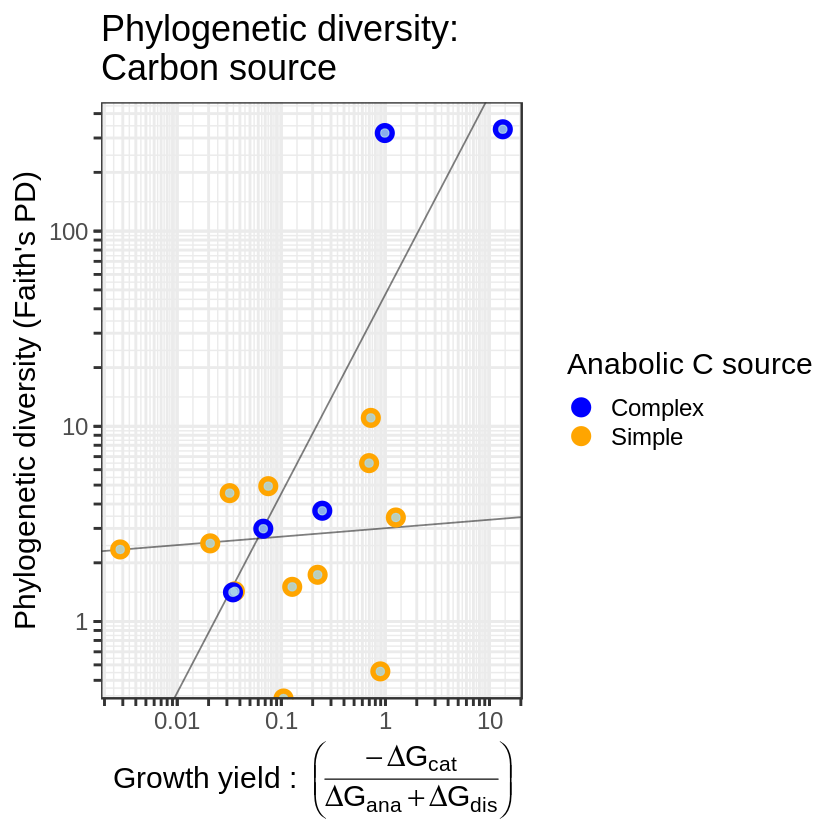

In [56]:
pd_plot_yield

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”


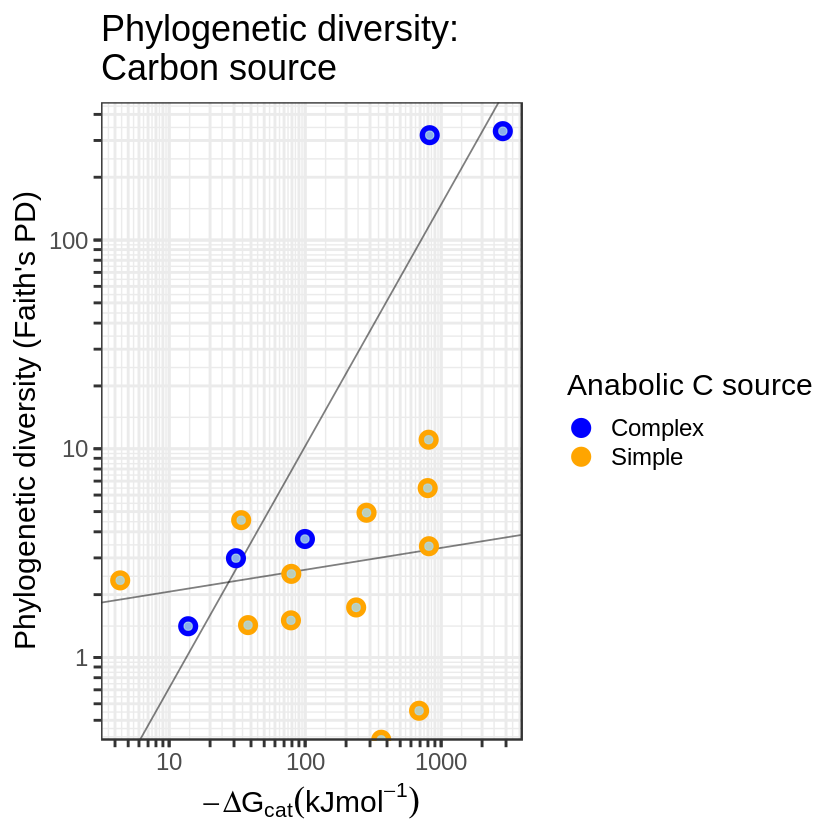

In [57]:
pd_plot_dgcat